# Mathematics of Machine Learning
## Chapter 2: Linear predictors
### Section 2.1: The Perceptron algorithm

#### Python script for applying the Perceptron algorithm to the MNIST dataset

### Script for evaluating the perceptron-learned hypothesis for MNIST.

### (0) Preliminaries
Loading required libraries and load the data

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt 

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from my_perceptron_exercise import my_perceptron  # see: my_perceptron.py

# change font size for all matplotlib plots
import matplotlib
matplotlib.rc('font', size=14)

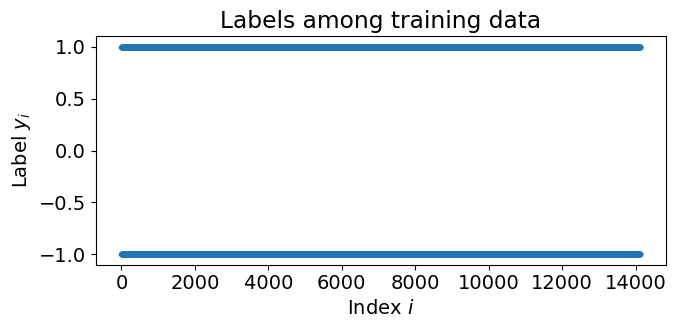

In [2]:
# Load data 
# WARNING: This can take some time
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='auto')

# Extracting "7" and "8"
ind = np.concatenate(np.where( (y == '7') | (y == '8')))
X = X[ind,:].T
y = y[ind]

# Transfoming feature to [0,1]
X = X/np.max(X)

# Transfoming the labels into +1 (7) and -1 (8)
y[np.where(y=='7')]=1
y[np.where(y=='8')]=-1

# Plotting distribution of label on training data
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(np.arange(np.size(y)), y, ".")
ax.set_title("Labels among training data")
ax.set_xlabel("Index $i$")
ax.set_ylabel("Label $y_i$")
fig.tight_layout()
plt.show()

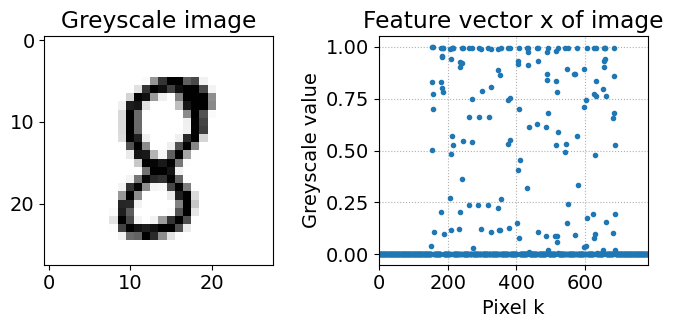

In [3]:
# Plotting one greyscale image and its feature vector
i = 1500
im = np.array(X[:,i])
im.resize(28,28)

plt.rcParams.update({'font.size': 14})
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7, 3.5))
ax1.imshow(im, cmap = "Greys")
ax1.set_title("Greyscale image")
ax2.plot(np.arange(784), X[:,i], ".")
ax2.set_title("Feature vector x of image")
ax2.set_xlabel("Pixel k")
ax2.set_ylabel("Greyscale value")
ax2.grid(linestyle='dotted')
ax2.set_xlim(0, 783)
fig.tight_layout()
plt.show()

### (1) Apply the perceptron algorithm

In [4]:
%%time

# WARNING: This can take some time
[w, T, ws, RSs] = my_perceptron(x=X, y=y, b=1, n_iter=2000, rng=np.random.default_rng(seed=17))

# Output final empirical risk (= misclassification rate)
RSs[-1], 1 - RSs[-1]

CPU times: total: 28.3 s
Wall time: 31.3 s


(0.005949851253718657, 0.9940501487462814)

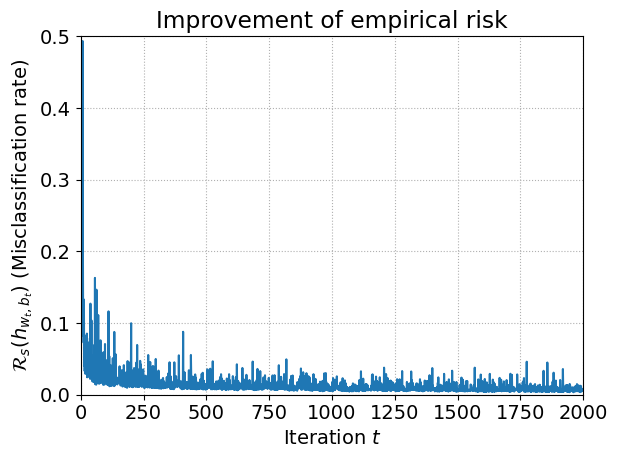

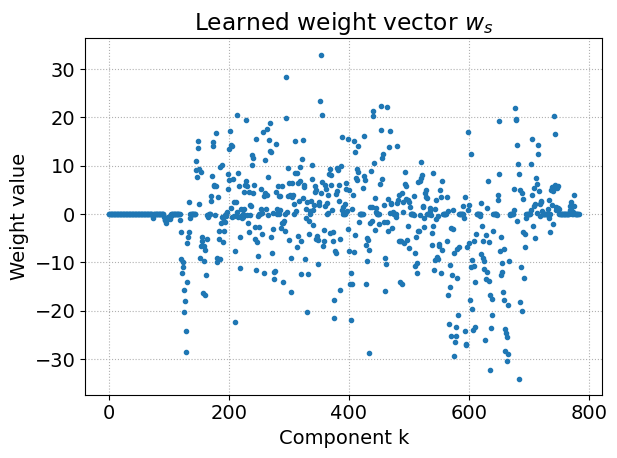

w[-1] = 86.0


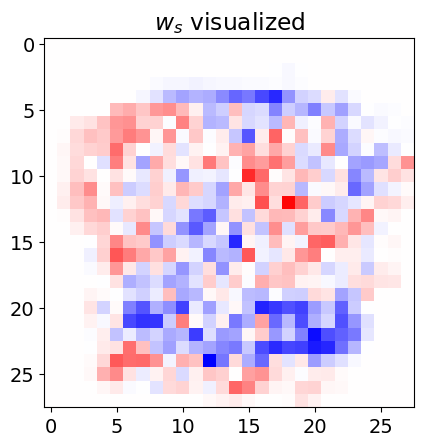

w[-1] = 86.0


In [5]:
# Plot "improvement" in empirical risk
fig, ax = plt.subplots()
ax.plot(np.arange(T), RSs[1:], "-")
ax.set_title("Improvement of empirical risk")
ax.set_xlabel("Iteration $t$")
ax.set_ylabel("$\mathcal{R}_s(h_{w_t,b_t})$ (Misclassification rate)")
ax.set(xlim=(0, T), ylim=(0, 0.5))
ax.grid(linestyle='dotted')
fig.tight_layout()
plt.show()

# Plot learned weight vector w_s and output learned bias b_s
fig, ax = plt.subplots()
ax.plot(np.arange(784), w[:784], ".")
ax.set_title("Learned weight vector $w_s$")
ax.set_xlabel("Component k")
ax.set_ylabel("Weight value")
ax.grid(linestyle='dotted')
ax2.set_xlim(0, 783)
fig.tight_layout()
plt.show()
print("w[-1] =", w[-1])


# Plot learned weight vector w_s and output learned bias b_s
fig, ax = plt.subplots()
coef = w[:784]
scale = np.abs(coef).max()
ax.imshow(
        coef.reshape(28, 28),
        interpolation="nearest",
        cmap = "bwr",
        vmin=-scale,
        vmax=scale,
    )
ax.set_title("$w_s$ visualized")
plt.show()
print("w[-1] =", w[-1])

In [6]:
# Definition of the learned hypothesis outputting "7" and "8"
h_S = lambda x, w: 7.5 - 0.5 * np.sign(w @ np.append(x, 1))

### (2) Find misclassified images

In [7]:
# the number m of training data
m = y.shape[0]

# Function to check the constraints
check = lambda w, x, y, m: y * (w @ np.append(x, np.ones((1, m)), axis=0))

# find indices of misclassified images
inds = np.where( check(w, X, y, y.shape[0]) < 0 )[0]

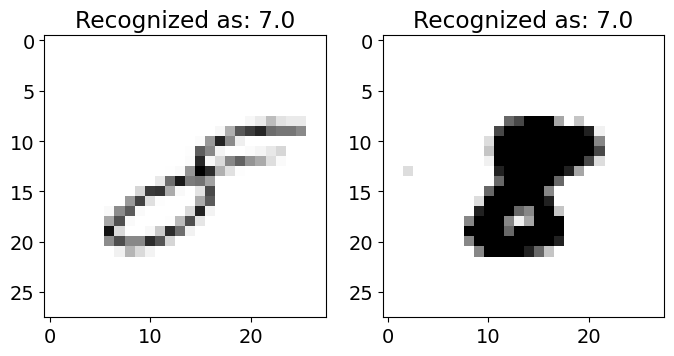

In [8]:
# Plot first of these pictures
x_first = X[:,inds[0]]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8, 4))
ax1.imshow(np.reshape(x_first, (28, 28)), cmap="Greys")
ax1.set_title(f"Recognized as: {h_S(x_first, w)}")

# plot the last of these pictures
x_last = X[:,inds[-1]]
ax2.imshow(np.reshape(x_last, (28, 28)), cmap="Greys")
ax2.set_title(f"Recognized as: {h_S(x_last, w)}")
plt.show()

### (3) Select correctly classified image and fool the Perceptron

In [9]:
# find indexes of correctly classified images
ch = check(w, X, y, m)
inds_correct = np.where(ch>0)[0]

In [10]:
# Random selection by random component of indexes
rng=np.random.default_rng(seed=42)
i = rng.choice(inds_correct)
i

1258

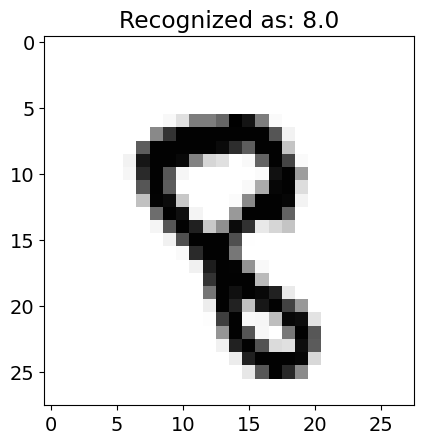

In [11]:
# plot the image
x_item = X[:,i]
y_item = y[i]
im = plt.imshow(np.reshape(x_item, (28, 28)), cmap='Greys')
plt.title(f'Recognized as: {h_S(x_item, w)}')
plt.show()

#### (3a) Compute perturbation "by hand"

In [12]:
import time

In [13]:
start = time.time()

In [23]:
# determine direction of perturbation v (depending on the label of x)
if y_item > 0: 
    v = w * (w < 0)
    # 2. v = w * (w > 0)
else:
    # 1. v = w * (w < 0)
    v = w * (w > 0)

# omit bias
v = v[:-1]

# find correct scale e:

# 1. e = -1.1 * w @ x_item / (w @ v)
# 2. e = -1.1 * w @ np.append(x_item, 1) / (w @ v)
# 3. e = -1.1 * w @ x_item / (w[:-1] @ v)
e = -1.1 * w @ np.append(x_item, 1) / (w[:-1] @ v)

# Checking whether thereafter actually misclassified
(y_item * w @ np.append(x_item + e*v, 1)) < 0

True

In [15]:
end = time.time()
print('Total runing time: ', end - start)

Total runing time:  0.015577077865600586


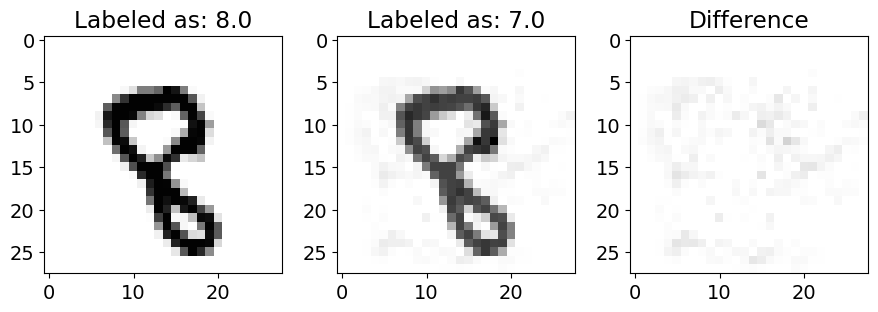

In [16]:
# Plot the images and pertubations
fig, axs = plt.subplots(1, 3, figsize = (9,9))
axs_0 = axs[0].imshow(np.reshape(x_item, (28, 28)), cmap='Greys')
axs[0].set_title(f'Labeled as: {h_S(x_item, w)}')
axs[1].imshow(np.reshape(x_item + e*v, (28, 28)), cmap='Greys')
axs[1].set_title(f'Labeled as: {h_S(x_item + e*v, w)}')
im = axs[2].imshow(np.reshape(e*v, (28, 28)), cmap='Greys', vmax=1, vmin = 0)
axs[2].set_title('Difference')
fig.tight_layout()
plt.show()

#### (3b) Compute perturbation by optimization

In [18]:
start = time.time()

In [19]:
# Compute minimal perturbation by optimization

# target
# 1. fun = lambda x: np.sqrt(sum((x-x_item)*2))
fun = lambda x: sum((x-x_item)**2)
# 3. fun = lambda x: sum((x-x_item)^2)

# linear_constraint (= to be misclassified)
d = X.shape[0]
coef = w[:784]
b = w[-1]

# 1. con = opt.LinearConstraint(y_item * coef , ub = y_item * b)
con = opt.LinearConstraint(y_item * coef , ub = -y_item * b)
# 3. con = opt.LinearConstraint(coef , ub = -b)
# 4. con = opt.LinearConstraint(coef , ub = b)

# Constraint optimization ensuring the greyscales are between 0 and 1:

# 1. opt_perturb = opt.minimize(fun, x_item, bounds = ((0,1),) * d, constraints = con, method='SLSQP')
# 1. x_perturb = opt_perturb.x

# 2. opt_perturb = opt.minimize(fun, x_item + e*v, bounds = ((0,1),) * d, method='SLSQP')
# 2. x_perturb = opt_perturb.x

# 3. opt_perturb = opt.minimize(fun, x_item + e*v, constraints = con, method='SLSQP')
# 3. x_perturb = opt_perturb.x

opt_perturb = opt.minimize(fun, x_item + e*v, bounds = ((0,1),) * d, constraints = con, method='SLSQP')
x_perturb = opt_perturb.x

In [20]:
end = time.time()
print('Total runing time: ', end - start)

Total runing time:  14.69389533996582


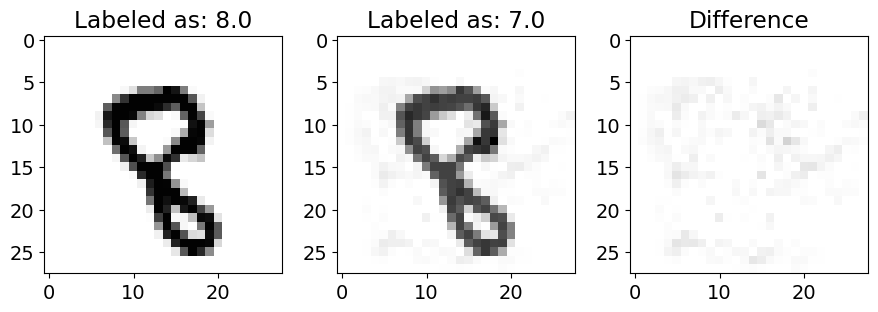

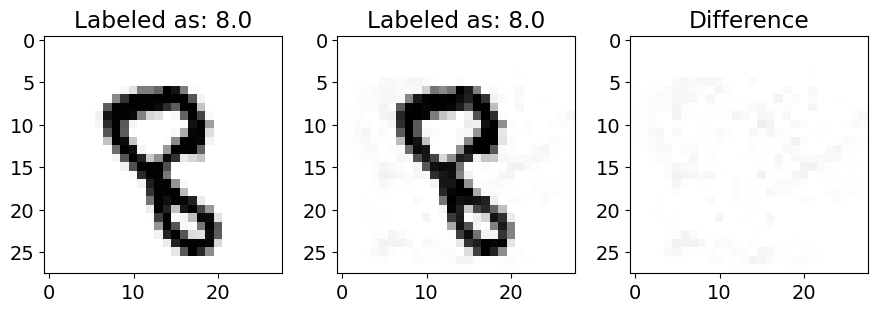

In [21]:
# Plot the images and pertubations computed by hand
fig, axs = plt.subplots(1, 3, figsize = (9,9))
axs_0 = axs[0].imshow(np.reshape(x_item, (28, 28)), cmap='Greys')
axs[0].set_title(f'Labeled as: {h_S(x_item, w)}')
axs[1].imshow(np.reshape(x_item + e*v, (28, 28)), cmap='Greys')
axs[1].set_title(f'Labeled as: {h_S(x_item + e*v, w)}')
im = axs[2].imshow(np.reshape(e*v, (28, 28)), cmap='Greys', vmax=1, vmin = 0)
axs[2].set_title('Difference')
fig.tight_layout()
plt.show()

# Plot the images and pertubations computed by optimization
fig, axs = plt.subplots(1, 3, figsize = (9,9))
axs_0 = axs[0].imshow(np.reshape(x_item, (28, 28)), cmap='Greys')
axs[0].set_title(f'Labeled as: {h_S(x_item, w)}')
axs[1].imshow(np.reshape(x_perturb, (28, 28)), cmap='Greys')
axs[1].set_title(f'Labeled as: {h_S(x_perturb, w)}')
im = axs[2].imshow(np.reshape(x_perturb - x_item, (28, 28)), cmap='Greys', vmax=1, vmin = 0)
axs[2].set_title('Difference')
fig.tight_layout()
plt.show()

### (4) Check for overfitting during training

In [24]:
X.shape

(784, 14118)

In [25]:
# Split data into training and testing data

# 1. X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 17, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size = 0.3, random_state = 17, shuffle=True)
# 3. X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 17, shuffle=True)
# 4. X_train, X_test, y_train, y_test = train_test_split(X.T, y, train_size = 0.7, random_state = 17, shuffle=True)

X_train = X_train.T
X_test = X_test.T

In [26]:
%%time
# WARNING: This can take some time
[w, T, ws, RSs] = my_perceptron(x=X_train, y=y_train, b=1, n_iter=5000, rng=np.random.default_rng(seed=17))
print(T)

# Output final empirical risk (= misclassification rate)
RSs[-1], 1 - RSs[-1]

3213
CPU times: total: 35.5 s
Wall time: 43.2 s


(0.0, 1.0)

In [27]:
# Compute the test error during the iterations

# Function to check the constraints
check = lambda w, x, y, m: y * (w @ np.append(x, np.ones((1, m)), axis=0))

# Calculation of the obtained test risk
# 1. m_test = X_test.shape[0]
m_test = X_test.shape[1]

R_test = lambda w: np.mean(check(w, X_test, y_test, m_test)  <= 0)
# 2. R_test = lambda w: np.mean(check(w, X_test, y_test, m_test)  > 0)

R_tests = np.zeros(T+1)
for i in np.arange(T+1):
    R_tests[i] = R_test(ws[i])

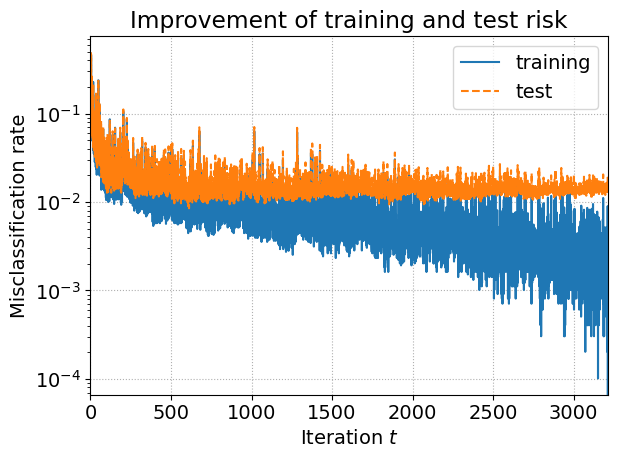

In [28]:
# Plot "improvement" in empirical risk
fig, ax = plt.subplots()
ax.plot(np.arange(T), RSs[1:], "-", label = "training")
ax.plot(np.arange(T), R_tests[1:], "--", label = "test")
ax.set_title("Improvement of training and test risk")
ax.set_xlabel("Iteration $t$")
ax.set_ylabel("Misclassification rate")
ax.set_yscale("log")
ax.legend()
ax.set(xlim=(0, T))
ax.grid(linestyle='dotted')
fig.tight_layout()
plt.show()

In [29]:
np.argmin(R_tests)

613